In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  # Also needed for plt.title()

DESCRIPTIVE STATISTICS

In [22]:
df=pd.read_csv("C:/Users/Student/Documents/kaim documents/week 1/raw_analyst_ratings.csv/raw_analyst_ratings.csv")
df['headline_length'] = df['headline'].str.len()
print(df['headline_length'].describe())

count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


Text(0.5, 1.0, 'Distribution of Headline Length')

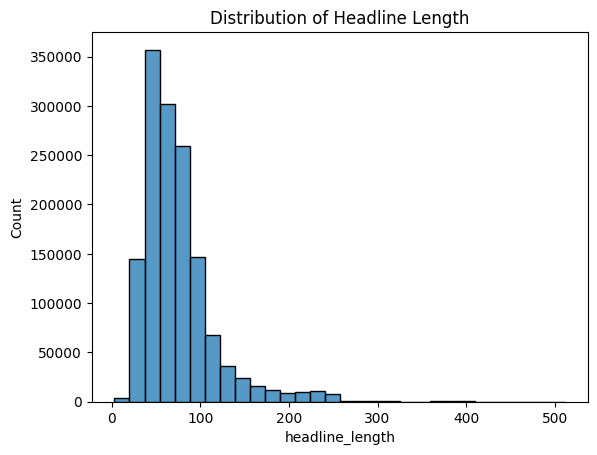

In [23]:
sns.histplot(df['headline_length'], bins=30)
plt.title('Distribution of Headline Length')


In [24]:
publisher_counts = df['publisher'].value_counts()
print(publisher_counts.head(10))

publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


Text(0.5, 1.0, 'Top 10 Most Active Publishers')

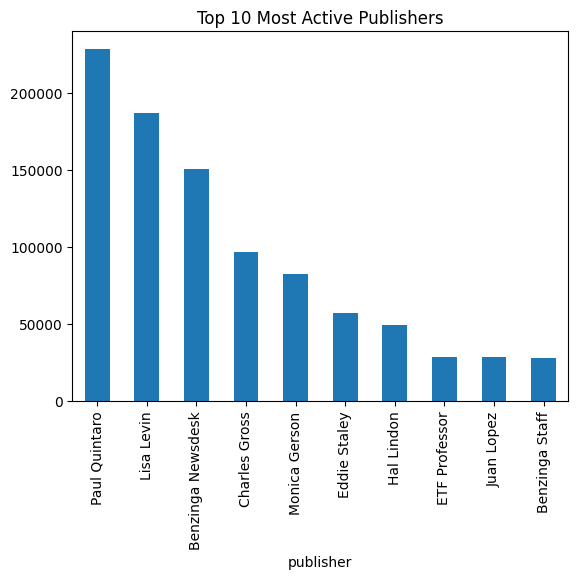

In [25]:
publisher_counts.head(10).plot(kind='bar')
plt.title('Top 10 Most Active Publishers')

In [26]:
df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')
df['day_of_week'] = df['date'].dt.day_name()

Text(0.5, 1.0, 'Number of Articles Over Time')

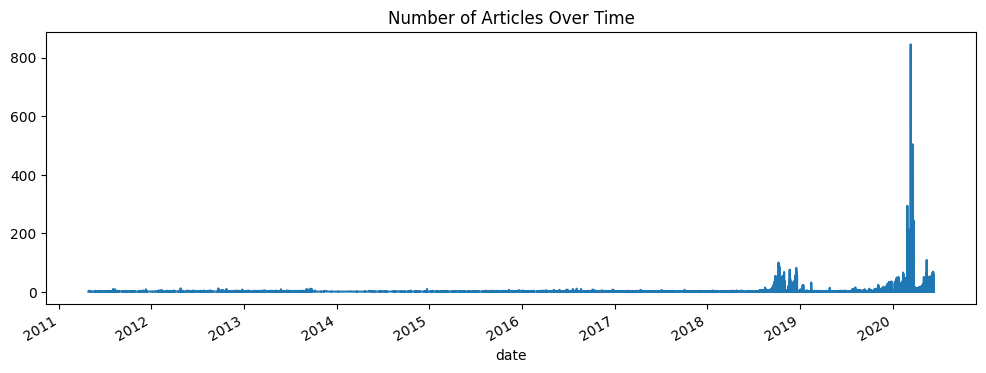

In [27]:
df['date'].value_counts().sort_index().plot(figsize=(12,4))
plt.title('Number of Articles Over Time')

Text(0.5, 1.0, 'Articles by Day of the Week')

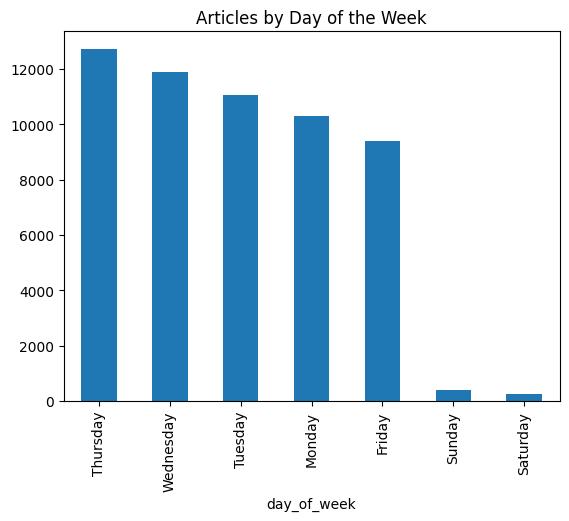

In [28]:
df['day_of_week'].value_counts().plot(kind='bar')
plt.title('Articles by Day of the Week')


TEXT ANALYSIS

In [29]:
%pip install nltk
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Student\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
%pip install gensim
import gensim
from gensim.utils import simple_preprocess

In [31]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess

stop_words = set(stopwords.words('english'))
def preprocess(text):
    return [word for word in simple_preprocess(text) if word not in stop_words]

df['tokens'] = df['headline'].apply(preprocess)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Student\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Time Series Analysis

Text(0.5, 1.0, 'Daily Publication Frequency')

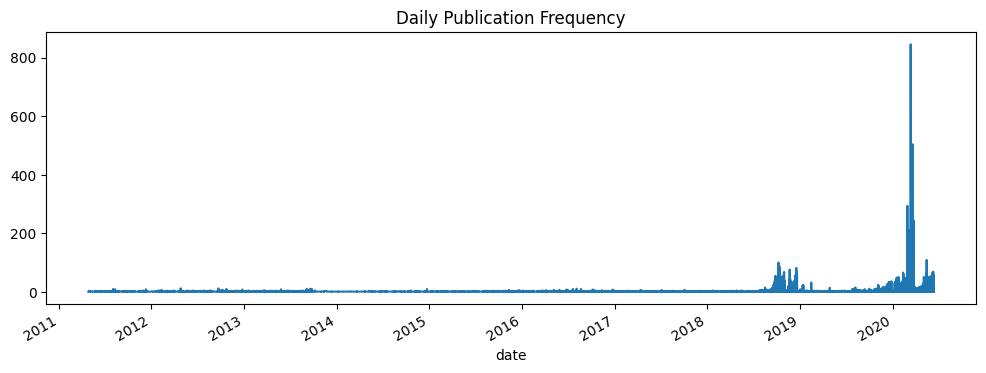

In [33]:
daily_counts = df['date'].value_counts().sort_index()
daily_counts.plot(figsize=(12,4))
plt.title('Daily Publication Frequency')

Text(0.5, 1.0, '7-Day Rolling Average of Publications')

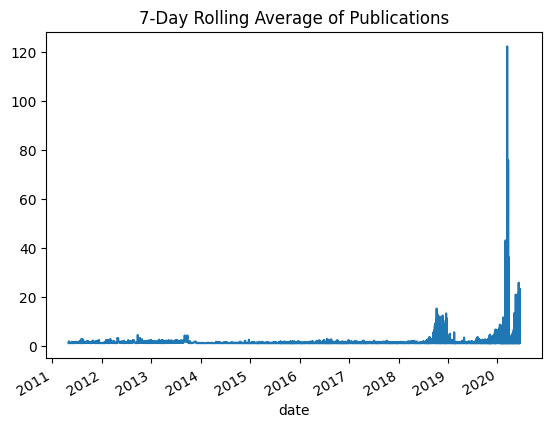

In [34]:
daily_counts.rolling(window=7).mean().plot()
plt.title('7-Day Rolling Average of Publications')


Text(0.5, 1.0, 'Articles Published by Hour')

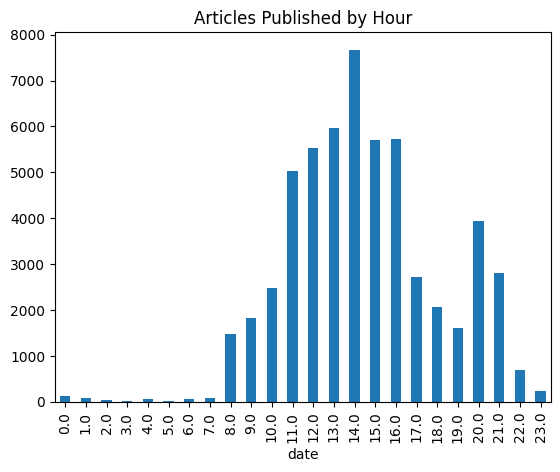

In [35]:
df['date'] = pd.to_datetime(df['date'], format='%H:%M:%S').dt.hour
df['date'].value_counts().sort_index().plot(kind='bar')
plt.title('Articles Published by Hour')


PUBLISHER ANAlYSIS

In [36]:
publisher_counts = df['publisher'].value_counts()
print(publisher_counts.head(10))

publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64
